In [ ]:
!pip install torch torchvision
!pip install d2l==1.0.0b0

# Quiz

# That TensorBoard playground

Did you beat me?

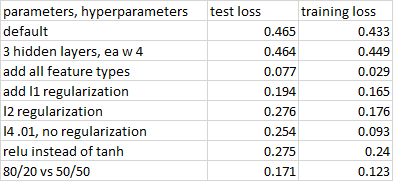

# Regression

Definition: "a statistical method ... that attempts to determine the strength and character of the relationship between one dependent variable (usually denoted by Y) and a series of other variables (known as independent variables)." (Investopedia)

Types:
* **linear**
* *logistic*
* polynomial
* ridge
* lasso
* elastic net
* poisson
* quantile

(and probably more!)

How to fit:
* analytical solutions
* approximation solutions


# Linear Regression

$y = w_1 x_1 + w_2 x_2 + ... + b$

The $w$ s are *weights*.

The $b$ is the *bias* (offset, intercept).

The $x$ s are  values of independent values (features).

The $y$ is the value of the dependent variable (label). For linear regression, the $y$ should be quantitative.

This function fits a **line**.

# Linear Regression and Matrix Math

Let's say we have ten data points and three independent variables.

In [ ]:
data = [[0,2,1], 
        [0,1,1], 
        [0,2,0], 
        [0,1,0], 
        [1,2,0], 
        [2,0,1], 
        [2,1,1], 
        [1,0,0], 
        [1,1,1]]

y = [6,4,5,3,6,4,6,2,5]

We want to figure out the $w$s and the $b$. Let's start by just making a guess.

In [ ]:
weights = [1,1,1]
bias = 0

Then we can use the dot product to figure out $\hat{y}$, the guesses at $y$ we get from our $w$s and $b$.

Now the shape of x is (3,1) and the shape of w is (3,1), so if we want to take a dot product we have to first take the transpose of w.

*Can you write this with just numpy?*

In [ ]:
import torch

w = torch.tensor(weights)

yHat = []
for row in data:
    x = torch.tensor(row)
    yHat.append((w.T.dot(x) + bias).tolist())

print(yHat)  

In fact, we can just do it all at once for all the data points!

*Can you write this with just numpy?*

In [ ]:
X = torch.tensor([x[0:3] for x in data])
print(X)

yHat = X@w + bias
print(yHat.tolist())

How good was our guess?

One measure we often use for "goodness of fit" of a linear regression is *mean sum of squared error*: $\frac{\sum_i \frac{1}{2}(\hat{y_i}-y_i)^2}{||y||}$

In [ ]:
sse = 0
for i in range(len(y)):
    sse += 1/2*(yHat[i]-y[i])**2

print(sse/len(y))

If we had picked our $w$ s and $b$ perfectly, what would the mean sum of squared error be?

# Linear Regression as a neural network

Right, so I think we can now frame linear regression as a neural network.

* The type of machine learning task will be regression.
* The *model architecture* will be a neural network.
  * The *width* will be the number of independent variables we have, plus one for the $b$.
  * The *depth* will be 1 - we have our input layer, then our output layer, and we are done.
  * The *connectedness* will be feedforward. We send data from the input layer to the output layer and that's all - no nodes in the input layer talk to each other.
  * The parameters of the model will be the $w$s and the $b$. These will be on the edges connecting the input layer to the output neuron.
  * Sometimes there are *hyperparameters* of the model architecture, but here there aren't any.
* The *loss function* (or optimization function) will be sum of squared error.
* We will fit this architecture using *gradient descent*.
  * This always has a *hyperparameter* for learning rate.
  * There may be other hyperparameters.

## In pytorch

First, we install required libraries.

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

We make the linear regression model architecture. Notice how in the constructor we have to specify:
* the number of inputs (width of the input layer)
* the learning rate (a *hyperparameter* of the optimization algorithm)
* sigma (another *hyperparameter* of the otpimization algorithm)

Then, we define how the neural network's neurons are connected.
* When we run a neural network - when we push data through til the output layer on a single data point - that's called a *forward pass*. 
* The forward pass implementation tells us how the input layer is connected to the output layer. We always represent this as matrix multiply of some kind.
* *What does the forward pass do in this case?*

And then, we define the loss function.

In [ ]:
class LinearRegressionScratch(d2l.Module):  #@save
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        print(self.w)
        self.b = torch.zeros(1, requires_grad=True)
        print(self.b)

    def forward(self, X):
        return torch.matmul(X, self.w) + self.b
    
    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()

Now we said before we would use *gradient descent* to train this model. Remember the boats from last class session?

Classic (pure) gradient descent goes like this:
1. Run *forward* on all your data.
2. Calculate the derivative of the *loss*.
3. Multiply the gradient by the *learning rate*.
4. Subtract that value from each of the model's parameters (in this case, $w$s and $b$). This step is called *backpropagation*.

However, this can be computationally expensive. There are many variants of gradient descent that are more efficient, including:
* Stochastic gradient descent - at each round, pick one training data point (at random) and run gradient descent just with that. 
* Minibatch stochastic gradient descent - at each round, pick $n$ training data points (at random) and run gradient descent just with that. (Normalize the learning rate by the minibatch size.)

What do we initialize the $w$ s and $b$ to at the beginning? Random values.

When do we stop? When either of the following is satisfied:
1. The loss has pretty much stopped changing.
2. We've run it for a preset maximum number of *epochs*.

In [ ]:
class SGD(d2l.HyperParameters):  #@save
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

We add this optimization algorithm to our linear regression model.

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

Then we augment the default pytorch trainer (defined in the book). It implements:
* for each epoch:
  * for each minibatch in the training data:
    * run forward (training_step)
    * calculate the loss
    * backward propagate the loss 
  * run evaluation on the validation data, report loss

In [ ]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

Let's try it!

In [ ]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

In [ ]:
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

*What happens when you change the number of epochs?*

*What happens when you change the learning rate?*

*How does all this compare to your project 1 adaline class?*